In [ ]:
!pip install scikit-image opencv-python imutils

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from cv2 import imread, imwrite, imshow, waitKey, destroyAllWindows, cvtColor, COLOR_BGR2RGB
from math import pi, cos, sqrt
from numpy import zeros, array, clip, trunc
from ipywidgets import widgets
from google.colab import files
import skimage.metrics
import scipy.sparse as sparse

import argparse
import imutils
import cv2

# Image Compression using SVD


In [ ]:
uploaded = files.upload()

Saving leaves_iso_200.ppm to leaves_iso_200.ppm
Saving nightshot_iso_100.ppm to nightshot_iso_100.ppm
Saving nightshot_iso_1600.ppm to nightshot_iso_1600.ppm
Saving big_building.ppm to big_building.ppm
Saving leaves_iso_1600.ppm to leaves_iso_1600.ppm
Saving hdr.ppm to hdr.ppm
Saving cathedral.ppm to cathedral.ppm
Saving big_tree.ppm to big_tree.ppm
Saving flower_foveon.ppm to flower_foveon.ppm
Saving bridge.ppm to bridge.ppm
Saving artificial.ppm to artificial.ppm
Saving fireworks.ppm to fireworks.ppm
Saving deer.ppm to deer.ppm
Saving spider_web.ppm to spider_web.ppm


In [ ]:
def divide_by_channel(image):
  image_red = image[:, :, 0]
  image_green = image[:, :, 1]
  image_blue = image[:, :, 2] 

  return image_red, image_green, image_blue


def construct_svd(matrix):
  U, d, V = np.linalg.svd(matrix, full_matrices=True)
  return U, d, V


def k_rank_approximation(u, d, v, k):
  u_k = u[:, 0:k]
  d_k = d[0:k]
  v_k = v[0:k, :]

  return u_k, d_k, v_k


def approximated_matrix(u_k, d_k, v_k):
  return np.dot(u_k, np.dot(np.diag(d_k), v_k))


def image_reconstruction(red_approx, green_approx, blue_approx, row, col):
  image_reconstructed = np.zeros((row, col, 3))

  image_reconstructed[:, :, 0] = red_approx
  image_reconstructed[:, :, 1] = green_approx
  image_reconstructed[:, :, 2] = blue_approx

  image_reconstructed[image_reconstructed < 0] = 0
  image_reconstructed[image_reconstructed > 1] = 1

  return image_reconstructed

def resolution(image):
  row, col, _ = image.shape
  return row, col

def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

In [ ]:
image = np.array(Image.open('hdr.ppm'))

image = image / 255

row, col, _ = image.shape

original_bytes = image.nbytes

image_red, image_green, image_blue = divide_by_channel(image)

U_r, d_r, V_r = construct_svd(image_red)
U_g, d_g, V_g = construct_svd(image_green)
U_b, d_b, V_b = construct_svd(image_blue)

bytes_to_be_stored = sum([matrix.nbytes for matrix in [U_r, d_r, V_r, U_g, d_g, V_g, U_b, d_b, V_b]])

Compression rate:  0.004069805145263672
SSIM: 0.898842269291329
PSNR: 23.350647139253624


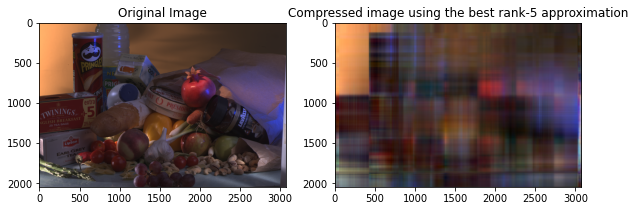

In [ ]:
k = 5

U_r_k, d_r_k, V_r_k = k_rank_approximation(U_r, d_r, V_r, k)
U_g_k, d_g_k, V_g_k = k_rank_approximation(U_g, d_g, V_g, k)
U_b_k, d_b_k, V_b_k = k_rank_approximation(U_b, d_b, V_b, k)

compressed_bytes = sum([matrix.nbytes for matrix in [U_r_k, d_r_k, V_r_k, U_g_k, d_g_k, V_g_k, U_b_k, d_b_k, V_b_k]])
ratio = compressed_bytes / original_bytes

image_red_approx   = approximated_matrix(U_r_k, d_r_k, V_r_k)
image_green_approx = approximated_matrix(U_g_k, d_g_k, V_g_k)
image_blue_approx  = approximated_matrix(U_b_k, d_b_k, V_b_k)

reconstructed_image = image_reconstruction(image_red_approx, image_green_approx, image_blue_approx, row, col)

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(image)
a.set_title('Original Image')

a = fig.add_subplot(1, 3, 2)
plt.imshow(reconstructed_image)
a.set_title('Compressed image using the best rank-{} approximation'.format(k))

score = skimage.metrics.structural_similarity(image, reconstructed_image, multichannel=True)

error = skimage.metrics.peak_signal_noise_ratio(image, reconstructed_image)

print("Compression rate: ", ratio)
print("SSIM: {}".format(score))
print("PSNR: {}".format(error))

# Image Compression using DCT


In [ ]:
cos_backup = array([])

def cos_values(N):
    ret = zeros((N, N))
    for n in range(len(ret)):
        for k in range(len(ret[n])):
            ret[k, n] = cos(((pi * k) * (2 * n + 1)) / (2 * N))
    global cos_backup
    cos_backup = ret


def direct_dct(vector):
    N = len(vector)
    if len(cos_backup) != N:
        cos_values(N)
    vector = cos_backup.dot(vector)
    vector[0] = vector[0] * sqrt(1 / 2)
    vector = vector * sqrt(2 / N)
    return vector


def inverse_dct(vector):
    N = len(vector)
    if len(cos_backup) != N:
        cos_values(N)
    vector[0] = vector[0] * sqrt(1 / 2)
    vector = vector * sqrt(2 / N)
    return cos_backup.T.dot(vector)


def direct_dct_2d(matrix):
    Nx, Ny = matrix.shape
    for line in range(Nx):
        matrix[line] = direct_dct(matrix[line])
    for column in range(Ny):
        matrix[:, column] = direct_dct(matrix[:, column])
    return matrix


def inverse_dct_2d(matrix):
    Nx, Ny = matrix.shape
    for column in range(Ny):
        matrix[:, column] = inverse_dct(matrix[:, column])
    for line in range(Nx):
        matrix[line] = inverse_dct(matrix[line])
    return matrix


def direct_dct_image(img):
    global cos_backup
    cos_backup = array([])
    if img.shape[2] == 3:
        for i in range(3):
            img[:, :, i] = direct_dct_2d(img[:, :, i])
    else:
        img[:, :, 0] = direct_dct_2d(img[:, :, 0])
    return img


def inverse_dct_image(y_compressed, shape):

    img = np.zeros(shape)
    for y_i in range(3):
        img[:, :, y_i] = y_compressed[y_i].todense()


    if img.shape[2] == 3:
        for i in range(3):
            img[:, :, i] = inverse_dct_2d(img[:, :, i])
    else:
        img[:, :, 0] = inverse_dct_2d(img[:, :, 0])
    return img.clip(0, 255)


def remove_coeficients_from_image(img, keep):
    img_new = np.zeros(img.shape)

    for i in range(keep * 3):  # * 3, because 3 color channels
        index = np.unravel_index(np.absolute(img).argmax(), img.shape)
        img_new[index] = img[index]  # copy it over to new image
        img[index] = 0  # remove from original so we don't count it again

    # previous method: lowpass filter
    # img[keep:, :, :] = 0
    # img[:, keep:, :] = 0

    img_compressed = np.array([sparse.csr_matrix(img_new[:, :, y_i]) for y_i in range(3)])
    return img_compressed

In [ ]:
compression_rate_dct = dict()
score_dct = dict()
error_dct = dict()
images_dct = []
image = np.array(Image.open('flower_foveon.ppm'))

image = image / 255

row, col, _ = image.shape

original_bytes = image.nbytes

x = direct_dct_image(image.copy())
k = 200

y = remove_coeficients_from_image(x.copy(), k)

compressed_dst_image_bytes = np.array([y[i].data.nbytes for i in range(3)]).sum()+y.nbytes

decompressedImage = inverse_dct_image(y, image.shape)

decompressedImage = np.where(decompressedImage > 1, 1, decompressedImage)
decompressedImage = np.where(decompressedImage < 0, 0, decompressedImage)

ratio =  compressed_dst_image_bytes / original_bytes

sc = skimage.metrics.structural_similarity(image, decompressedImage, multichannel=True)
er = skimage.metrics.peak_signal_noise_ratio(image, decompressedImage)

compression_rate_dct[k] = ratio
score_dct[k] = sc
error_dct[k] = er

Compression rate:  5.861398057165253e-05


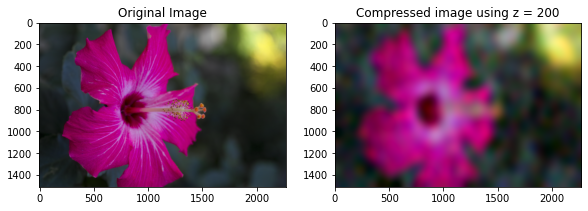

In [ ]:
fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(np.array(Image.open('flower_foveon.ppm')))
a.set_title('Original Image')

a = fig.add_subplot(1, 3, 2)
plt.imshow(decompressedImage)
a.set_title('Compressed image using z = {}'.format(k))

print("Compression rate: ", compression_rate_dct[k])